<a href="https://colab.research.google.com/github/Justworkname/Tamil_lab_Chance_Gammill/blob/main/Copy_of_Transformer_Classification_V2_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Classification 2.5

## Import/Install

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'6 16 2023 Meeting.gslides'
 6367
'7 12 2023 meeting.gslides'
 7340
'8 17 2023 meeting.gslides'
'8 30 2023 meeting.gslides'
'9 06 2023 meeting - Bar chart 1.gsheet'
'9 06 2023 meeting - Column chart 1 (1).gsheet'
'9 06 2023 meeting - Column chart 1 (2).gsheet'
'9 06 2023 meeting - Column chart 1.gsheet'
'9 06 2023 meeting.gslides'
'9 20 2023 meeting.gslides'
'AI in Breast Cancer in Medical Imaging.gslides'
 AI_MB
 AI_MB_3D
'Colab Notebooks'
 customTF2
 Data_Vision_Transformer
 fakeImages
 Grad_documents
'Invited Lecture September 19th.gdoc'
'My Drive'
'Presentation Evaluation sep 19.gdoc'
 Seminar
 Ultrasound_Images
 Undergrad_documents
'Veterinary Clinic Tumor Estimation Conclusion.gslides'
'Wild Magic.gsheet'


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import os
from PIL import Image
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare Data

In [ ]:
desiredHeight=512
desiredWidth=512
input_shape = (512, 512, 3)
threshold = 0.9

In [ ]:
# Load the CSV file into a DataFrame
csv_file_path = '/content/gdrive/MyDrive/Data_Vision_Transformer/Data_Entry_2017_IM1.csv'
df = pd.read_csv(csv_file_path)

# Classification of collumn
all_classifications = df['Finding Labels'].str.split('|').explode()
unique_classes = all_classifications.unique()
num_unique_classes = len(unique_classes)

# Just for test
# print(f"There are {num_unique_classes} unique classes in the dataset.")

# Path to the folder containing images
image_folder = '/content/gdrive/MyDrive/Data_Vision_Transformer/images/'
image_data = []
classifications_data = []

# Load images
for index, row in df.head(2000).iterrows():
    image_file_name = row['Image Index']

    # Full path
    image_path = image_folder + image_file_name

    try:
        img = Image.open(image_path)
        img = img.resize((desiredWidth, desiredHeight))
        # RGBA->RGB noticed some issue with and will fix later
        img = img.convert('RGB')
        img_array = np.array(img)
        image_data.append(img_array)
        # Extract classification and other information from the DataFrame
        classifications = row['Finding Labels'].split('|')
        classifications_data.append(classifications)

        # other_info = row['Other Information']

    except Exception as e:
        print(f"Error processing {image_file_name}: {str(e)}")
        sys.exit('Image not Found')

image_data = np.array(image_data)
classifications_data = [np.array(classifications) for classifications in classifications_data]

In [ ]:
classifications_data = np.array(classifications_data)

x_train, x_test, y_train, y_test = train_test_split(image_data, classifications_data, test_size=0.2, random_state=42, shuffle=True)

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


<ipython-input-6-b67abb5db1e7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  classifications_data = np.array(classifications_data)


x_train shape: (1600, 512, 512, 3) - y_train shape: (1600,)
x_test shape: (400, 512, 512, 3) - y_test shape: (400,)


## Hyperparameters

In [ ]:
learning_rate = 0.000005
weight_decay = 0.0001
batch_size = 5
num_epochs = 40
image_size = 512  # We'll resize input images to this size
patch_size = 64
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 10 # It's likely that with the given scope of the question, that it is too few layers
mlp_head_units = [2048, 1024]

## Augment Data

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization()
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

## Implement MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [ ]:
# Seperates into patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Display Patches

Image size: 512 X 512
Patch size: 64 X 64
Patches per image: 64
Elements per patch: 12288


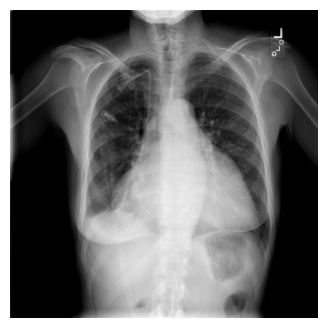

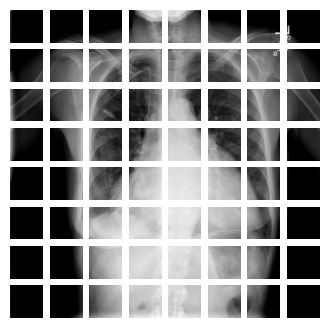

In [ ]:
# Displays patches, no impact on network
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(desiredHeight, desiredWidth)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        # This is the built in keras command that allows for ViT the math behind it is hard
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # Compute positions as a 1D tensor with shape (num_patches,)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [tf.shape(patch)[0], 1])
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## ViT model

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

def create_multilabel_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Pre-Normalization
    pre_norm = preprocessing.Normalization(axis=-1)
    x1 = pre_norm(encoded_patches)

    for _ in range(transformer_layers):
        # Creates a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Post-Normalization
        post_norm = preprocessing.Normalization(axis=-1)
        x3 = post_norm(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Post-Normalization
    post_norm = preprocessing.Normalization(axis=-1)
    representation = post_norm(encoded_patches)

    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # End of basic transformer
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs for multilabel classification using sigmoid activation.
    # Tried to change type to bfloat16 did not work
    logits = layers.Dense(num_classes, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compile the model
    model.compile(
        optimizer='adam', # Can not be adamW
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

KeyboardInterrupt: ignored

## Compile, train, and evaluate the mode

In [ ]:
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer

# Create a MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the multiclass labels
y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.fit_transform(y_test)

# Each row corresponds to a sample, and each column corresponds to a class
# print(y_train_encoded)
# print(y_test_encoded)

# Reverse mapping (index to label)
# Careful using this in python
index_to_label = {index: label for index, label in enumerate(mlb.classes_)}
print(index_to_label)

{0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Consolidation', 3: 'Edema', 4: 'Effusion', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Infiltration', 8: 'Mass', 9: 'No Finding', 10: 'Nodule', 11: 'Pleural_Thickening', 12: 'Pneumonia', 13: 'Pneumothorax'}


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
# Not all of the above ended up staying in the final code, I just dont remember which

accuracies = []
epochs = []
num_classes = num_unique_classes

# Model function
def run_experiment(model, epoch):

    optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train_encoded,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)

    _, accuracy = model.evaluate(x_test, y_test_encoded)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Create and compile
vit_classifier = create_multilabel_vit_classifier()

# Training loop
for epoch in range(1, num_epochs + 1):
    run_experiment(vit_classifier, epoch)

# After training is complete, plot the accuracy values over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('accuracy_over_epochs.png')  # Save the plot as an image
plt.show()

Epoch 1/40
 60/288 [=====>........................] - ETA: 3:31 - loss: 32.2132 - accuracy: 0.1367

In [ ]:
# Save your model using the variable name 'vit_classifier'
vit_classifier.save('vit_classifier_model.h5')

In [ ]:
# Register the custom 'Patches' layer before loading the model
keras.utils.get_custom_objects()['Patches'] = Patches
# Register the custom 'Patches' layer before loading the model
keras.utils.get_custom_objects()['PatchEncoder'] = PatchEncoder

#Load the saved model
loaded_model = keras.models.load_model('vit_classifier_model.h5')